 # Maketh
This tutorial will guide you through the implementation of a bare-bones cryptocurrency in Python. By the end of this tutorial you will have:
- Understood the core concepts of blockchain (in the context of Bitcoin)
- Implemented several key blockchain algorithms on a high-level
- Built a rudimentary, hackable blockchain (don't worry, you'll hack it yourself first)

The currency that you will build today is similar to Bitcoin. As such, I will explain core blockchain concepts in the context of Bitcoin. Since I'll often use specefic examples, certain parts of this guide may not be true for another cryptocurrency or project implemented on a blockchain. The cryptocurrency that you build will feature only the minimal funtionality required to be considered a **local** cryptocurrency. This means that it can only be run on a singular node, and is constrained to, your computer. Consider this tutorial an educational introduction to the various elements that comprise a blockchain:

1. Wallets
1. Transactions
1. Blocks
1. Mining
1. Consensus

We'll start with the smallest elements then work our way to more macro concepts, building incrementally on what we've learned.

## Circa 2008
Let's start by bringing down most (if not all) major banks across the globe. We'll do this be giving people a way to store money securely on their own computers. We'll call this wizardary a "wallet," as it serves the same purpose as a tangible wallet, that is, to hold money.

In [205]:
import binascii
import Crypto
import Crypto.Random
from Crypto.Hash import SHA
from Crypto.PublicKey import RSA
from Crypto.Signature import PKCS1_v1_5

class Wallet(object):
    """ Public key/private key pair """
    
    def __init__(self):
        random_gen = Crypto.Random.new().read
        self._private_key = RSA.generate(1024, random_gen)
        self._public_key = self._private_key.publickey()
        self._signer = PKCS1_v1_5.new(self._private_key)
        
    @property
    def address (self):
        """ Address is pubic key """
        return binascii.hexlify(self._public_key.exportKey(format='DER')).decode('ascii')
    
    def sign(self, message):
        """ Sign a transaction with this wallet """
        h = SHA.new(message.encode('utf8'))
        return binascii.hexlify(self._signer.sign(h)).decode('ascii')
    
def verify_signature(wallet_address, message, signature):
    """ Check that the provided `signature` corresponds to `message`
    signed by the wallet at `wallet_address` """
    pubkey = RSA.importKey(binascii.unhexlify(wallet_address))
    verifier = PKCS1_v1_5.new(pubkey)
    h = SHA.new(message.encode('utf8'))
    return verifier.verify(h, binascii.unhexlify(signature))

# create a new wallet
w1 = Wallet()

# sign the wallet
signature = w1.sign('My first wallet')

# verify address
assert verify_signature(w1.address, 'My first wallet', signature)

# verify address with incorrect signature
assert not verify_signature(w1.address, 'rogue message', signature)

## The Sacred Box
Consider for a moment that you were worthy enough to be given the Sacred Box. The Sacred Box permits you to lay pieces of paper within its chambers. When you close the Box and shake it, the word on the paper somehow changes to a seemingly gibberish sequence of [alphanumeric](https://en.wikipedia.org/wiki/Alphanumeric) characters.

<img src="imgs/sacred_box/example_one.png">

For the sake of simplicity, let's attribute the conversion to *magic*. How does the Sacred Box compute the end word? Not a singular human in the world is sure (that's not really true). Despite this, we adore the Sacred Box. As it is Sacred, we *must* not question it, but rather observe. What happens when we put a different word into the Sacred Box? What if we put a recieved output back into the Sacred Box? Let us be guided by the box. Put in the pieces of paper, close the box, and shake it.

<img src="imgs/sacred_box/example_two.png">

Suprisingly, when given an alphanumeric string of characters (in this case, "A6XBDEGK") the Sacred Box cannot determine the original word that was put in it. That is because, in the eyes of the Sacred Box, all inputs are the same (we have much to learn from the Sacred Box). Furthermore, we are now certain that it can **only** convert inputs into gibberish. This is okay. The Sacred Box is sacred, and has endured much, therefore we will always adore it. Notice how putting in a different word converted that word to another seemingly random sequence of characters.  It is important to understand that **whenever the same word is entered into the Sacred Box, the resulting output will always be the same**.

### Et tu, Box-te?
The Sacred Box is a sham. 

What if I told you that the Box was based in sound, logical, mathematical reasoning. Would you feel duped? Brace yourselves: our sacred box is just a mathematical [hash function](https://en.wikipedia.org/wiki/Hash_function). 

Humans are such fickle minded beings.  

This box is the most fundamental component of Bitcoin (and most blockchains). Hashes are not a concept unique to Bitcoin or cryptocurrencies. In fact, in computer science, A hash function just serves to map (or "reformat") data of an arbitrary size to data of a fixed size. This output is called a digest. Let's see an implementation of this in Python. Luckily for us Python has a package in the Standard Library that includes a number of hash functions.

In [206]:
import hashlib

def sha256(data):
    """ Map data to a fixed digest """
    return hashlib.sha256(data.encode("ascii")).hexdigest()

def sacred_box(data):
    """ Return a formatted digest """
    return "{}: {}".format(data, sha256(data))


""" EXAMPLES """
print(sacred_box("CANNABIS"))

# changing even just one character significantly 
# impacts the resulting digest
print(sacred_box("DANNABIS"))

# notice how the same input always
# returns the same output
print(sacred_box("CANNABIS"))

CANNABIS: 5de87455cbe2bbf661db741dafc556c656a72512ece65a4182fa18e44bfc56c8
DANNABIS: fd0ce5549345e2074a31bc56bbea5017aff686aebc3100dfd3b9218c113acb07
CANNABIS: 5de87455cbe2bbf661db741dafc556c656a72512ece65a4182fa18e44bfc56c8


Recall happens when the outputs of the Sacred Box are passed back into it and it is shook again. Now, what would happen if you hash the digest of the word "CANNABIS"? Test your theory by trying it in the cell above.

---

## Transactions
Hashes are an essential part of Bitcoin. After seralization, each transaction undergoes two rounds of the same hash function ([sha256](https://en.wikipedia.org/wiki/SHA-2)) that we used in our cryptocurrency to create a **Transaction Identifier (TXID)**. When working with systems of scale, much like Bitcoin, fractions of seconds come into play. A transaction sometimes contains too much data for it to be passed between nodes effectively (too many bits). Bitcoin uses a hash function to remap the data to a fixed length to serve the same general purpose that the blockchain needs. We use hashes because they are one way functions. It is easy to compute the output of a hash funciton given its input, but it is very difficult (read: impossible, probably) to obtain the input of a hash function given the output (the hash function itself cannot compute it). Transactions gain a layer of security and efficiency when we hash its contents.

In Bitcoin, transactions are just records that a wallet was decreased of a certain balance and that another wallet was increased of that same balance. This is comprised of:
- A spender, who will sign the transaction
- A number of inputs, which are other transactions' outputs. The recipient of all those should be the spender's wallet, otherwise you could spend other people's money.
- A number of outputs, each of which specify an amount of money and a recipient

In [207]:
import json
import numpy as np

class TransactionInput(object):
    """ An input for a transaction. This points to an output of another transaction """
    def __init__(self, transaction, output_index):
        self.transaction = transaction
        self.output_index = output_index
        assert 0 <= self.output_index < len(transaction.outputs)
        
    def to_dict(self):
        d = {
            'transaction': self.transaction.hash(),
            'output_index': self.output_index
        }
        return d
    
    @property
    def parent_output(self):
        return self.transaction.outputs[self.output_index]
    

class TransactionOutput(object):
    """ An output for a transaction. This specifies an amount and a recipient (wallet) """
    def __init__(self, recipient_address, amount):
        self.recipient = recipient_address
        self.amount = amount
        
    def to_dict(self):
        d = {
            'recipient_address': self.recipient,
            'amount': self.amount
        }
        return d

        
def compute_fee(inputs, outputs):
    """ Compute the transaction fee by computing the difference between total input and total output """
    total_in = sum(i.transaction.outputs[i.output_index].amount for i in inputs)
    total_out = sum(o.amount for o in outputs)
    assert total_out <= total_in, "Invalid transaction with out(%f) > in(%f)" % (total_out, total_in)
    return total_in - total_out

    
class Transaction(object):
    def __init__(self, wallet, inputs, outputs):
        """ Create a transaction spending money from the provided wallet """
        self.inputs = inputs
        self.outputs = outputs
        self.fee = compute_fee(inputs, outputs)
        self.signature = wallet.sign(json.dumps(self.to_dict(include_signature=False)))
        
    def to_dict(self, include_signature=True):
        d = {
            "inputs": list(map(TransactionInput.to_dict, self.inputs)),
            "outputs": list(map(TransactionOutput.to_dict, self.outputs)),
            "fee": self.fee
        }
        if include_signature:
            d["signature"] = self.signature
        return d
    
    def hash(self):
        return sha256(json.dumps(self.to_dict()))
    
# We need to propogate our blockchain with a root 
# transaction, as all transactions need a parent transaction
class GenesisTransaction(Transaction):
    """ This is the first transaction which is a special transaction
    with no input and 25 unit output """
    def __init__(self, recipient_address, amount=25):
        self.inputs = []
        self.outputs = [
            TransactionOutput(recipient_address, amount)
        ]
        self.fee = 0
        self.signature = 'genesis'
        
    def to_dict(self, include_signature=False):
        assert not include_signature, "Cannot include signature of genesis transaction"
        return super().to_dict(include_signature=False)

Example transaction between Alice and Bob.

In [208]:
alice = Wallet()
bob = Wallet()

t1 = GenesisTransaction(alice.address)
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 2.0), TransactionOutput(alice.address, 22.0)]
)

assert np.abs(t2.fee - 1.0) < 1e-5

In bitcoin, you never store how much you have in your wallet. Instead, you go through the whole chain of transactions to compute how much you have. Let's write a function to do that. First, let's send a few more transactions between Alice, Bob, and their friend, Walter.

In [209]:
alice = Wallet()
bob = Wallet()
walter = Wallet()

# This gives 25 coins to Alice
t1 = GenesisTransaction(alice.address)

# Of those 25, Alice will spend
# Alice -- 5 --> Bob
#       -- 15 --> Alice
#       -- 5 --> Walter
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 5.0), TransactionOutput(alice.address, 15.0), TransactionOutput(walter.address, 5.0)]
)

# Walter -- 5 --> Bob
t3 = Transaction(
    walter,
    [TransactionInput(t2, 2)],
    [TransactionOutput(bob.address, 5.0)])

# Bob -- 8 --> Walter
#     -- 1 --> Bob
#        1 fee
t4 = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)

# creating a list of transactions with which to compute the balance
transactions = [t1, t2, t3, t4]

Now, let's compute the balance of our transactions.

In [210]:
def compute_balance(wallet_address, transactions):
    """ Given an address and a list of transactions, computes 
    the wallet balance of the address """
    balance = 0
    for t in transactions:
        # Subtract all the money that the address sent out
        for txin in t.inputs:
            if txin.parent_output.recipient == wallet_address:
                balance -= txin.parent_output.amount
        # Add all the money received by the address
        for txout in t.outputs:
            if txout.recipient == wallet_address:
                balance += txout.amount
    return balance

print("Alice  has %.02f units" % compute_balance(alice.address, transactions))
print("Bob    has %.02f units" % compute_balance(bob.address, transactions))
print("Walter has %.02f units" % compute_balance(walter.address, transactions))

Alice  has 15.00 units
Bob    has 1.00 units
Walter has 8.00 units


We also want to be able to verify that a transaction is valid. This means :
1. You can only spend your money. This means checking that all inputs are owned by the transaction's owner
1. Ensure you don't spend more than you have. This is checked by the compute_fee function above.

In [211]:
import logging

def verify_transaction(transaction):
    """ Verify that the transaction is valid.
    We need to verify two things :
    - That all of the inputs of the transaction belong to the same wallet
    - That the transaction is signed by the owner of said wallet """
    tx_message = json.dumps(transaction.to_dict(include_signature=False))
    if isinstance(transaction, GenesisTransaction):
        # TODO: We should probably be more careful about validating genesis transactions
        return True
    
    # Verify input transactions
    for tx in transaction.inputs:
        if not verify_transaction(tx.transaction):
            logging.error("Invalid parent transaction")
            return False
    
    # Verify a single wallet owns all the inputs
    first_input_address = transaction.inputs[0].parent_output.recipient
    for txin in transaction.inputs[1:]:
        if txin.parent_output.recipient != first_input_address:
            logging.error(
                "Transaction inputs belong to multiple wallets (%s and %s)" %
                (txin.parent_output.recipient, first_input_address)
            )
            return False
    
    if not verify_signature(first_input_address, tx_message, transaction.signature):
        logging.error("Invalid transaction Signature, Trying to spend someone else's money?")
        return False
    
    # Call compute_fee here to trigger an assert if output sum is great than input sum. Without this,
    # a miner could put such an invalid transaction.
    compute_fee(transaction.inputs, transaction.outputs)
    
    return True


t1 = GenesisTransaction(alice.address)
# This is an invalid transaction because bob is trying to spend alice's money
# (alice was the recipient of the input - t1)

t2 = Transaction(
    bob,
    [TransactionInput(t1, 0)],
    [TransactionOutput(walter.address, 10.0)]
)

# This is valid, alice is spending her own money
t3 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(walter.address, 10.0)]
)

In [212]:
assert verify_transaction(t1)

In [213]:
assert not verify_transaction(t2)

ERROR:root:Invalid transaction Signature, Trying to spend someone else's money?


In [214]:
assert verify_transaction(t3)

# Transactions in Blocks
Now that we have :
- A way to define a wallet (as a private/public key pair)
- A way to create transactions between wallets
- A way to verify transactions (by checking the signature matches

What remains is to group transactions into blocks and have miners mine blocks. Mining a block consists of two parts :

1. Verifying the transactions in the block
1. Finding a nonce such that the block's hash starts with a number of 0

Also, mining generates money by the convention that the first transaction in a block is a GenesisTransaction that gives 25 coins to whatever address the miner chose. In the same way, the miner can add transactions to redirect the fees from the transactions in the block to whatever address it chooses.

## Mining
Now, the process of mining is : given an arbitrary string $x$, find a nonce such that $hash(x + nonce)$ produces a hash starting with a number of leading ones.

For example here, we'll "mine" a nonce such that the hash of our message ("hello bitcoin") when concatenated with our nonce will have at least 2 leading ones.

In [215]:
message = 'hello bitcoin'
for nonce in range(1000):
    digest = sha256(message + str(nonce))
    if digest.startswith('11'):
        print('Found nonce = %d' % nonce)
        break
        
print(sha256(message + str(nonce)))



Found nonce = 32
112c38d2fdb6ddaf32f371a390307ccc779cd92443b42c4b5c58fa548f63ed83


The more you increase the number of leading ones you require, the harder it becomes (on average) to find a nonce. In bitcoin, this is called the mining difficulty. Note that bitcoin doesn't require a number of leading digits, but instead requires the hash to be below a certain value. But it's the same idea.

So let's define two functions that we'll reuse later: one to hash a string and one to mine a nonce for a given string.

In [216]:
def mine(message, difficulty=1):
    """
    Given an input string, will return a nonce such that
    hash(string + nonce) starts with `difficulty` ones
    
    Returns: (nonce, niters)
        nonce: The found nonce
        niters: The number of iterations required to find the nonce
    """
    assert difficulty >= 1, "Difficulty of 0 is not possible"
    i = 0
    prefix = '1' * difficulty
    while True:
        nonce = str(i)
        digest = sha256(message + nonce)
        if digest.startswith(prefix):
            return nonce, i
        i += 1
        

import numpy as np
import pandas as pd
import pylab as pl
import string
import random
import matplotlib
%matplotlib inline

def random_string(length=10):
    return ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(length))

strings = [random_string() for i in range(50)]

In [217]:
levels = range(1, 5)
# An array of results with a row for each difficulty and a column for each test string
results = pd.DataFrame(index=strings, columns=levels, dtype=np.int)
results.fillna(value=0)

,1,2,3,4
0IZ2LCGU0V,0,0,0,0
DOGFHHT4P9,0,0,0,0
A46ZO7C5R0,0,0,0,0
QLJR9N2P23,0,0,0,0
V4JC3XRZYB,0,0,0,0
R3ZRZO7S3H,0,0,0,0
AFD8M7ZW3J,0,0,0,0
F5P8FZ2QF7,0,0,0,0
YT8W7WYSK2,0,0,0,0
NL4YRBU238,0,0,0,0


In [226]:
#results = np.zeros((N_LEVELS, len(strings)), dtype=np.int)
for level in levels:
    for s in strings:
        _, niters = mine(s, difficulty=level)
        results[level][s] = niters

In [219]:
results.iloc[:5]

,1,2,3,4
0IZ2LCGU0V,3,42,2385,21090
DOGFHHT4P9,9,145,746,746
A46ZO7C5R0,42,245,2626,44701
QLJR9N2P23,35,104,539,61128
V4JC3XRZYB,2,16,14432,38752


Text(0,0.5,'Iterations')

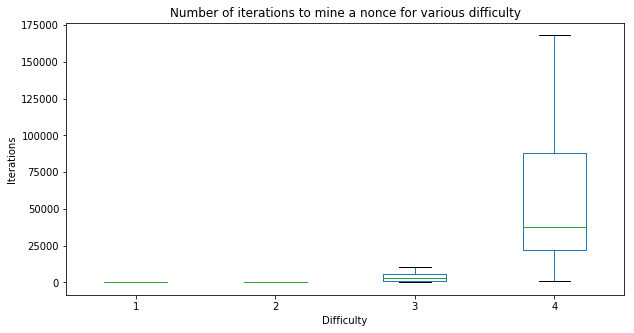

In [227]:
pl.figure(figsize=(10, 5))
ax = pl.subplot(111)
ax.set_title('Number of iterations to mine a nonce for various difficulty')
results.plot.box(showfliers=False, ax=ax)
ax.set_xlabel('Difficulty')
ax.set_ylabel('Iterations')

With that, we can mine nononces of varied difficulties.

In [221]:
nonce, niters = mine('42', difficulty=1)
print('Took %d iterations' % niters)

nonce, niters = mine('42', difficulty=3)
print('Took %d iterations' % niters)

Took 23 iterations
Took 2272 iterations


As you can see in this example, the number of iterations required for a difficulty of 3 is much larger than for a difficulty of 1. Note though that you could get lucky and have a string where the first nonce (0 in our case) would yield the solution. So the difficulty controls the average number of tries.

Now we can create a block.

In [222]:
BLOCK_INCENTIVE = 25 # The number of coins miners get for mining a block
DIFFICULTY = 2


def compute_total_fee(transactions):
    """Return the total fee for the set of transactions"""
    return sum(t.fee for t in transactions)


class Block(object):
    def __init__(self, transactions, ancestor, miner_address, skip_verif=False):
        """
        Args:
            transactions: The list of transactions to include in the block
            ancestor: The previous block
            miner_address: The address of the miner's wallet. This is where the block
                           incentive and the transactions fees will be deposited
        """
        reward = compute_total_fee(transactions) + BLOCK_INCENTIVE
        self.transactions = [GenesisTransaction(miner_address, amount=reward)] + transactions
        self.ancestor = ancestor
        
        if not skip_verif:
            assert all(map(verify_transaction, transactions))
        
        json_block = json.dumps(self.to_dict(include_hash=False))
        self.nonce, _ = mine(json_block, DIFFICULTY)
        self.hash = sha256(json_block + self.nonce)
        
    def fee(self):
        """Return transaction fee for this block"""
        return compute_total_fee(self.transactions)
    
    def to_dict(self, include_hash=True):
        d = {
            "transactions": list(map(Transaction.to_dict, self.transactions)),
            "previous_block": self.ancestor.hash,
        }
        if include_hash:
            d["nonce"] = self.nonce
            d["hash"] = self.hash
        return d
    
    
class GenesisBlock(Block):
    """
    The genesis block is the first block in the chain.
    It is the only block with no ancestor
    """
    def __init__(self, miner_address):
        super(GenesisBlock, self).__init__(transactions=[], ancestor=None, miner_address=miner_address)

    def to_dict(self, include_hash=True):
        d = {
            "transactions": [],
            "genesis_block": True,
        }
        if include_hash:
            d["nonce"] = self.nonce
            d["hash"] = self.hash
        return d

Similarly to how we verify transactions, we also need a way to verify blocks :

In [223]:
def verify_block(block, genesis_block, used_outputs=None):
    """
    Verifies that a block is valid :
    - Verifies the hash starts with the required amount of ones
    - Verifies that the same transaction output isn't used twice
    - Verifies all transactions are valid
    - Verifies the first transaction in the block is a genesis transaction with BLOCK_INCENTIVE + total_fee
    
    Args:
        block: The block to validate
        genesis_block: The genesis block (this needs to be shared by everybody. E.g. hardcoded somewhere)
        used_outputs: list of outputs used in transactions for all blocks above this one
    """
    if used_outputs is None:
        used_outputs = set()
    
    # Verify hash
    prefix = '1' * DIFFICULTY
    if not block.hash.startswith(prefix):
        logging.error("Block hash (%s) doesn't start with prefix %s" % (block.hash, prefix))
        return False
    if not all(map(verify_transaction, block.transactions)):
        return False
    
    # Verify that transactions in this block don't use already spent outputs
    #
    # Note that we could move this in verify_transaction, but this would require some passing the used_outputs
    # around more. So we do it here for simplicity
    for transaction in block.transactions:
        for i in transaction.inputs:
            if i.parent_output in used_outputs:
                logging.error("Transaction uses an already spent output : %s" % json.dumps(i.parent_output.to_dict()))
                return False
            used_outputs.add(i.parent_output)
    
    # Verify ancestors up to the genesis block
    if not (block.hash == genesis_block.hash):
        if not verify_block(block.ancestor, genesis_block, used_outputs):
            logging.error("Failed to validate ancestor block")
            return False
    
    # Verify the first transaction is the miner's reward
    tx0 = block.transactions[0]
    if not isinstance(tx0, GenesisTransaction):
        logging.error("Transaction 0 is not a GenesisTransaction")
        return False
    if not len(tx0.outputs) == 1:
        logging.error("Transactions 0 doesn't have exactly 1 output")
        return False
    reward = compute_total_fee(block.transactions[1:]) + BLOCK_INCENTIVE
    if not tx0.outputs[0].amount == reward:
        logging.error("Invalid amount in transaction 0 : %d, expected %d" % (tx0.outputs[0].amount, reward))
        return False
    
    # Only the first transaction shall be a genesis
    for i, tx in enumerate(block.transactions):
        if i == 0:
            if not isinstance(tx, GenesisTransaction):
                logging.error("Non-genesis transaction at index 0")
                return False  
        elif isinstance(tx, GenesisTransaction):
            logging.error("GenesisTransaction (hash=%s) at index %d != 0", tx.hash(), i)
            return False
    return True

""" EXAMPLE """
alice = Wallet()
bob = Wallet()
walter = Wallet()

genesis_block = GenesisBlock(miner_address=alice.address)
print("genesis_block : " + genesis_block.hash + " with fee=" + str(genesis_block.fee()))

t1 = genesis_block.transactions[0]
t2 = Transaction(
    alice,
    [TransactionInput(t1, 0)],
    [TransactionOutput(bob.address, 5.0), TransactionOutput(alice.address, 15.0), TransactionOutput(walter.address, 5.0)]
)
t3 = Transaction(
    walter,
    [TransactionInput(t2, 2)],
    [TransactionOutput(bob.address, 5.0)])

t4 = Transaction(
    bob,
    [TransactionInput(t2, 0), TransactionInput(t3, 0)],
    [TransactionOutput(walter.address, 8.0), TransactionOutput(bob.address, 1.0)]
)

block1 = Block([t2], ancestor=genesis_block, miner_address=walter.address)
print("block1        : " + block1.hash + " with fee=" + str(block1.fee()))

block2 = Block([t3, t4], ancestor=block1, miner_address=walter.address)
print("block2        : " + block2.hash + " with fee=" + str(block2.fee()))

genesis_block : 1162dce8ffec3acf13ce61109f121922eee8cceeea4784aa9d90dc6ec0e0fa92 with fee=0
block1        : 1175461e273005dcd2510755f1b79fa6d92016430037a6532face0ea65548621 with fee=0.0
block2        : 11812dcc657fb9e5862dbc146606ae4dad95c50739dcde5941eda26b7535c01a with fee=1.0


In [224]:
verify_block(block1, genesis_block)
verify_block(block2, genesis_block)

True

In [225]:
def collect_transactions(block, genesis_block):
    """Recursively collect transactions in `block` and all of its ancestors"""
    # Important : COPY block.transactions
    transactions = [] + block.transactions
    if block.hash != genesis_block.hash:
        transactions += collect_transactions(block.ancestor, genesis_block)
    return transactions

transactions = collect_transactions(block2, genesis_block)

# Alice mined 25 (from the genesis block) and gave 5 to bob and 5 to walter
print("Alice  has %.02f units" % compute_balance(alice.address, transactions))
# Bob received 5 from alice and 5 from walter, but then back 8 to walter with a transaction fee of 1
print("Bob    has %.02f units" % compute_balance(bob.address, transactions))
# Walter mined 2 blocks (2 * 25), received 8 from bob and go a transaction fee of 1 on block2
print("Walter has %.02f units" % compute_balance(walter.address, transactions))

Alice  has 15.00 units
Bob    has 1.00 units
Walter has 59.00 units
